In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Tophat2DKernel

from regions import CircleSkyRegion

from gammapy.data import DataStore
from gammapy.background import RingBackgroundEstimator, AdaptiveRingBackgroundEstimator
from gammapy.detect import compute_lima_image
from gammapy.image import SkyImage

from sky_image_estimator import IACTSkyImageEstimator

In [3]:
REFERENCE_WCS = {'nxpix': 400,
                 'nypix': 400,
                 'xref': 83.633083, 
                 'yref': 22.0145,
                 'coordsys': 'CEL',
                 'proj': 'CAR'}
EMIN, EMAX = [1, 10] * u.TeV
IMAGE_REF = SkyImage.empty(**REFERENCE_WCS)

In [4]:
# setup data store and get list of observations
data_store = DataStore.from_dir('$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2/')
observations = data_store.obs_list([23523, 23526, 23559, 23592])

In [5]:
# define exlusion mask
center = SkyCoord(83.633083, 22.0145, frame='icrs', unit='deg')
exclusion_region = CircleSkyRegion(center, radius=Angle(0.2, 'deg'))

exclusion_mask = IMAGE_REF.region_mask(exclusion_region)
exclusion_mask.data = ~exclusion_mask.data

In [6]:
# ring background parameters
r_in = 0.3 * u.deg
r_out_max = 1.3 * u.deg
width = 0.2 * u.deg
stepsize = 0.08 * u.deg
threshold_alpha = 0.25

# set up background estimator classes
background_estimator = RingBackgroundEstimator(r_in=r_in, width=width)
background_estimator_adaptive = AdaptiveRingBackgroundEstimator(r_in=r_in, r_out_max=r_out_max, width=width, stepsize=stepsize,
                                                                threshold_alpha=threshold_alpha)


# set up image estimator
image_estimator = IACTSkyImageEstimator(reference=IMAGE_REF, emin=EMIN, emax=EMAX,
                                        background_estimator=background_estimator_adaptive,
                                        exclusion_mask=exclusion_mask)

In [7]:
# run image estimator
images = image_estimator.run(observations)

/home/hfm/adonath/Software/Repositories/gammapy/gammapy/cube/core.py:84: RuntimeWarning: divide by zero encountered in log
  log_data = np.log(self.data.value)
/home/hfm/adonath/Software/Applications/anaconda3.5/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:2382: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]
/home/hfm/adonath/Software/Repositories/gammapy/gammapy/background/ring.py:128: RuntimeWarning: invalid value encountered in true_divide
  alpha_approx = np.where(exposure_off > 0, exposure_on / exposure_off, np.inf)


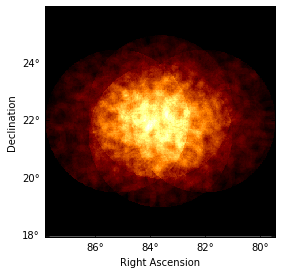

In [8]:
images['background'].show()

In [9]:
tophat = Tophat2DKernel(5)
tophat.normalize('peak')
lima_images = compute_lima_image(counts=images['counts'], background=images['background'], kernel=tophat)

/home/hfm/adonath/Software/Repositories/gammapy/gammapy/stats/poisson.py:237: RuntimeWarning: invalid value encountered in greater_equal
  mask = (n_on >= n_on_min)
/home/hfm/adonath/Software/Repositories/gammapy/gammapy/stats/poisson.py:254: RuntimeWarning: divide by zero encountered in true_divide
  term_b = sqrt(n_on * log(n_on / mu_bkg) - n_on + mu_bkg)


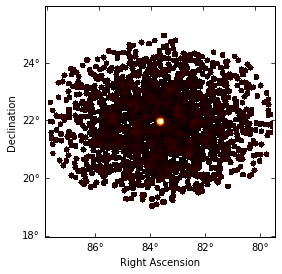

In [10]:
lima_images['significance'].show()